# Text Classification and Analysis
Now we're at the point where we should be able to:
* Read in a collection of documents - a *corpus* which contains the manually coded and predicted papers
* Do some preliminary data analysis and select only papers >= 2006
* Load the Spacy language model
* Do some text processing and lemmatize abstract using the Spcy lemmatizer
* Use TFIDF to fit and tranform the vectorized texts
* Implement NMF for topic modelling
* Implement t-SNE to visualize the topics
* Implement geoparsing

## Perform imports and load the dataset
The seen dataset contains the bibliometric information of over 1600 publications which have been manually labelled by two authors. Inconsistencies have been discussed and agreed upon. 

In [1]:
from typing import Tuple
import copy as cp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
### TODO Add your file path ###
file_path = '../Data/NewData_August2023/'
#File that was extracted from the big database having only labelled data. Relevant = 1 means relevant.
file_name = 'output_relevant_unseen_seen_merge_shuffle_August2023.xlsx'
df = pd.read_excel(file_path + file_name)

df.head()

Unnamed: 0                                           Abstract  Relevant  \
0        4749  Purpose The purpose of this paper is to demons...         0   
1        1483  Child-centred disaster risk reduction aims to ...         1   
2        3397  Educational attainment is generally a strong p...         0   
3        3918  Purpose The paper aims to respond to three que...         0   
4         246  The links between infrastructure and developme...         0   

                             DOI  \
0     10.1108/IJSHE-12-2019-0354   
1             10.1111/disa.12536   
2  10.1016/j.jclepro.2019.04.291   
3       10.1108/rmj-12-2020-0041   
4        10.1057/9781137541482_2   

                                               Title  \
0  Identifying and addressing reverse salients in...   
1  Returning to normal? 'Building back better' in...   
2  Climate change belief, sustainability educatio...   
3  Sometimes, green is the outcome: climate actio...   
4  What Drives Private Participation in Infrastru...   

                                        Source title  PubYear  \
0  INTERNATIONAL JOURNAL OF SUSTAINABILITY IN HIG...     2020   
1                                          DISASTERS     2022   
2                      Journal of Cleaner Production     2019   
3                         Records Management Journal     2021   
4                                                NaN     2015   

                                             Authors  Times cited  Probability  
0                        Berker, Thomas; Woods, Ruth            3       100.00  
1                                     Parham, Martin            0       100.00  
2                    Hess, David J.; Maki, Alexander           26       100.00  
3                                     Evans, Lois M.            0        99.99  
4  Moszoro, Marian; Araya, Gonzalo; Ruiz-Nuñez, F...            1       100.00

In [3]:
len(df)

18112

In [4]:
df.rename(columns={'Unnamed: 0': 'Identifier'}, inplace = True)

In [5]:
df['PubYear'] = df['PubYear'].astype(int)

In [ ]:
!pip install langdetect

In [ ]:
#Not implemented because only english paper selected 8some papers might have double laguage abstract)
from langdetect import detect
# Function to detect the language of text
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["detected_language"] = df["Abstract"].apply(detect_language)
 
# Filter for English text
#english_df = df[df["detected_language"] == "en"]

In [ ]:
# Display the DataFrame with English text --> only if needed
df[df.detected_language == 'en'].count()

In [ ]:
# Save DataFrame with English abstracts only --> only if needed
df = df[df.detected_language == 'en']

### Take a look at a typical abstract.

In [ ]:
df.info()

In [ ]:
from IPython.display import Markdown, display
display(Markdown('> '+df['Abstract'][250]))

### Detect & remove empty strings
Technically, we're dealing with "whitespace only" strings. If the original .xlsx file had contained empty strings, pandas **.read_xlsx()** would have assigned NaN values to those cells by default.

In order to detect these strings we need to iterate over each row in the DataFrame. The **.itertuples()** pandas method is a good tool for this as it provides access to every field. For brevity we'll assign the names `i`, `lb` and `rv` to the `index`, `DOI` and `Title` columns, but actually we need to define over which columns we want to irerate and the code below needs to reflect this.

In [ ]:
#This is not needed here but we keep it for reference in case we need it at some point
#blanks = []  # start with an empty list

#for i,lb,rv in df.itertuples():  # iterate over the DataFrame
#    if type(rv)==str:            # avoid NaN values
#        if rv.isspace():         # test 'review' for whitespace
#            blanks.append(i)     # add matching index numbers to the list
        
#print(len(blanks), 'blanks: ', blanks)

Next we'll pass our list of index numbers to the **.drop()** method, and set `inplace=True` to make the change permanent.

In [ ]:
#df.drop(blanks, inplace=True)

#len(df)

## Take a quick look at the `label` column:

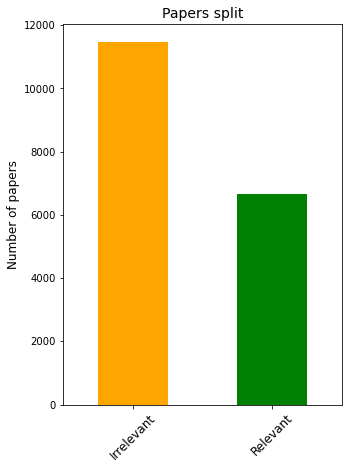

In [6]:
ax = df['Relevant'].value_counts().plot.bar(figsize = (5,7), color=['orange', 'green'])
ax.set_xticklabels(['Irrelevant','Relevant'], rotation = 45, fontsize=12)
ax.set_ylabel("Number of papers", fontsize=12)
ax.set_title('Papers split',fontsize=14)
plt.savefig('../Figure_GPT2_8/irrelevant_relevant_Split.eps', dpi='figure',format = 'eps',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [7]:
df['Relevant'].value_counts()

0    11463
1     6649
Name: Relevant, dtype: int64

In [8]:
npr = df[df['Relevant'] == 1]

In [9]:
npr.reset_index(inplace = True)

In [ ]:
plt.figure(figsize=(18,6))
subgrade_order = sorted(npr['PubYear'].dropna().astype(int).unique())
x1 = npr['PubYear'].dropna().astype(int)
chart = sns.countplot(x=x1,data=npr,order = subgrade_order, palette = 'coolwarm')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

None
#npr['PubYear'].value_counts().plot(kind = 'bar', figsize = (12,6))

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/3226285901.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_yticklabels(chart.get_yticks(), size = 15, )


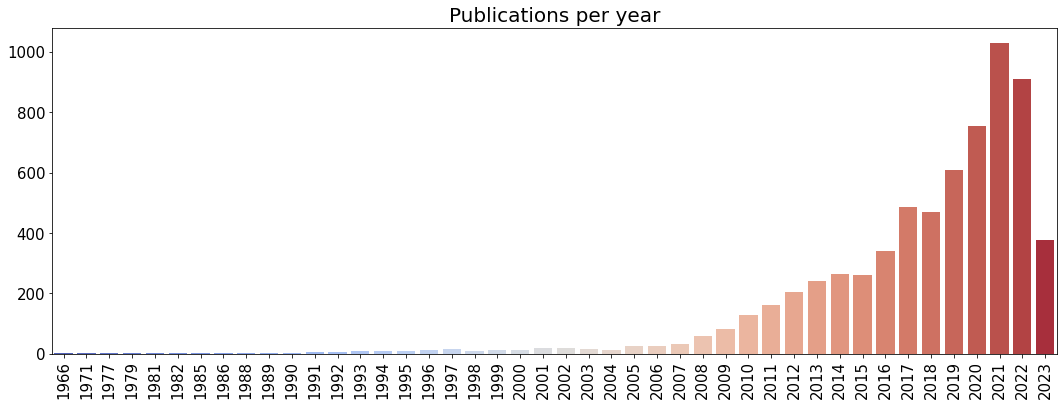

In [10]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(18,6))
subgrade_order = sorted(npr[npr['PubYear']>1960]['PubYear'].dropna().astype(int).unique())
x1 = npr['PubYear'].dropna().astype(int)
chart = sns.countplot(x=x1,data=npr,order = subgrade_order, palette = 'coolwarm')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, size =15)
chart.set_yticklabels(chart.get_yticks(), size = 15, )
chart.set_title("Publications per year", fontsize=20)
chart.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
chart.set_xlabel(xlabel = None)
chart.set_ylabel(ylabel = None)
plt.savefig('../Figure_GPT2_8/PubYear_All.eps', dpi='figure',format = 'eps',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
None

In [11]:
#Given the low number of papers before 2008 we keep only from 2008 onwards
npr_2008 = npr[npr['PubYear'] >=2008]

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/3999356952.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_yticklabels(chart.get_yticks(), size = 15)


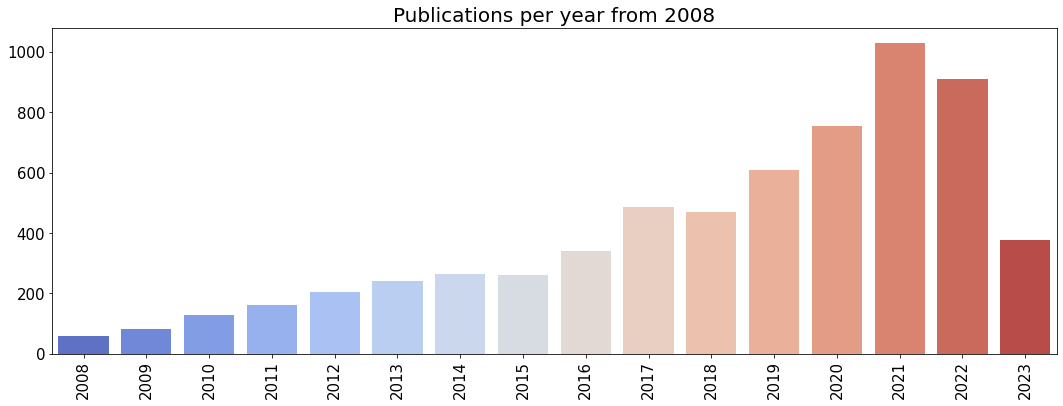

In [12]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(18,6))
subgrade_order = sorted(npr_2008['PubYear'].dropna().astype(int).unique())
x1 = npr_2008['PubYear'].dropna().astype(int)
chart = sns.countplot(x=x1,data=npr_2008,order = subgrade_order, palette = 'coolwarm')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, size =15)
chart.set_yticklabels(chart.get_yticks(), size = 15)
chart.set_title("Publications per year from 2008", fontsize=20)
chart.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
chart.set_xlabel(xlabel = None)
chart.set_ylabel(ylabel = None)
plt.savefig('../Figure_GPT2_8/PubYear_All_2006.eps', dpi='figure',format = 'eps',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
None

In [13]:
len(npr[npr['PubYear'] >= 2008])

6379

In [18]:
!python -m spacy validate

2023-10-27 08:23:55.401481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.5.2) =================
ℹ spaCy installation:
/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/spacy

NAME             SPACY            VERSION                       
en_core_web_sm   >=3.4.0,<3.5.0   3.4.0   --> 3.5.0
en_core_web_lg   >=3.4.0,<3.5.0   3.4.0   --> 3.5.0


============================== Install updates ==============================
Use the following commands to update the packages:
python -m spacy download en_core_web_sm
python -m spacy download en_core_web_lg



In [19]:
#Importa libraries for semantic analysis and other tasks
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
nlp = spacy.load("en_core_web_lg")

In [20]:
nlp.Defaults.stop_words |= {"climate","change","education", "climatic","changes","climat", "changing", "chang",
        "educ", "educational", "educative", "teach", "teaching","global", "warming", "die", 
                           "und", "das", "pro", "auf",'ll','ve', 'der', 'ein','sich', 'für'}

In [16]:
import requests
def britishize(string):
    url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
    american_to_british_dict = requests.get(url).json()    

    for american_spelling, british_spelling in american_to_british_dict.items():
        string = string.replace(american_spelling, british_spelling)
  
    return string

In [22]:
# We want all abstracts in british english
#Need a good network to run this because of the url request in the britishize function. 
npr_2008['Abstract_british'] = npr_2008['Abstract'].apply(lambda x: britishize(x))

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/623707576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2008['Abstract_british'] = npr_2008['Abstract'].apply(lambda x: britishize(x))


In [23]:
#Use the spacy lemmatizer to get the best result so far
npr_2008['abstract_lemmatized'] = npr_2008['Abstract_british'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/3856124538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2008['abstract_lemmatized'] = npr_2008['Abstract_british'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))


In [24]:
stop_words_2 = nlp.Defaults.stop_words

In [25]:
#tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range = (1,1), stop_words=stop_words_2)
#tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range = (1,2), stop_words=stop_words_2)
#tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range = (1,3), stop_words=stop_words_2)
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2), stop_words=stop_words_2)

In [26]:
dtm = tfidf.fit_transform(npr_2008['abstract_lemmatized'])

In [27]:
tfidf_weights = [(word, dtm.getcol(idx).sum()) for word, idx in tfidf.vocabulary_.items()]

In [28]:
feature_names = tfidf.get_feature_names_out()

In [29]:
from wordcloud import WordCloud
w = WordCloud(width=1000, height=800, mode='RGBA', background_color='white', max_words=500).fit_words(dict(tfidf_weights))

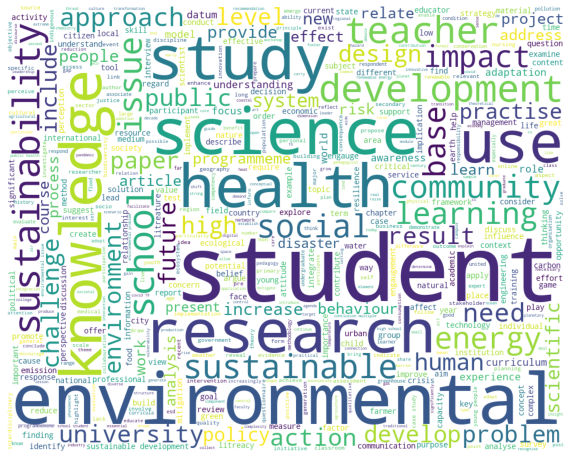

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('../Figure_GPT2_8/Climate_Education_500_12gram.eps', dpi='figure',format = 'eps',facecolor='auto', 
           edgecolor='auto',pad_inches=0.1)

In [31]:
occ = np.asarray(dtm.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': tfidf.get_feature_names_out(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(10)

term  occurrences
93325         student   164.430936
34106   environmental   142.540482
86747         science   116.219801
94241           study   105.918196
82468        research   104.876044
44472          health    99.500165
103183            use    95.463413
55117       knowledge    93.099123
26596     development    85.763611
97389         teacher    84.309838

In [33]:
weights = np.asarray(dtm.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf.get_feature_names_out(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=False).head(200)
weights_df.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Output_Data/term_weight_gram12.xlsx',index = False, header=True)
weights_df.head(10)

term    weight
93325         student  0.025777
34106   environmental  0.022345
86747         science  0.018219
94241           study  0.016604
82468        research  0.016441
44472          health  0.015598
103183            use  0.014965
55117       knowledge  0.014595
26596     development  0.013445
97389         teacher  0.013217

In [34]:
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
#add_stop = ['climate', 'change', 'education', 'science']
#stop_words = ENGLISH_STOP_WORDS.union(add_stop)
#nlp.Defaults.stop_words |= {"climate","change","education", "climatic","changes","climat", "changing", "chang",
#                           "educ", "educational", "educative", "teach", "teaching"}

stop_words = nlp.Defaults.stop_words

#nlp.Defaults.stop_words.add('climate','change','education')


# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [35]:
# Process the text
npr_2008['processed_text'] = npr_2008['abstract_lemmatized'].apply(process_text)

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/3659758762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2008['processed_text'] = npr_2008['abstract_lemmatized'].apply(process_text)


In [36]:
npr_2008.reset_index(inplace = True)

In [37]:
npr_2008.drop('level_0', inplace = True, axis = 1)

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/2454024092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2008.drop('level_0', inplace = True, axis = 1)


In [38]:
npr_2008.drop('index', inplace = True, axis = 1)

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/2051218654.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2008.drop('index', inplace = True, axis = 1)


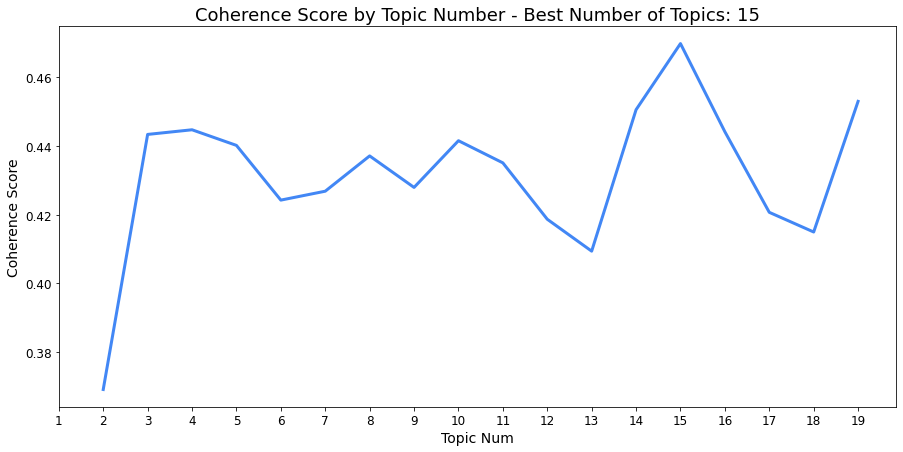

In [39]:
# Use Gensim's NMF to get the best num of topics via coherence score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter
texts = npr_2008['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
#topic_nums = list(np.arange(5, 75 + 1, 5))

topic_nums = list(np.arange(2, 20, 1))
# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(1, max(topic_nums) + 1, 1), fontsize=12)
plt.yticks(fontsize=12)

file_name = 'c_score'

fig.savefig(
    file_path + file_name + '.eps',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [40]:
from sklearn.decomposition import NMF

In [41]:
nmf_model = NMF(n_components=15,random_state=43,alpha = 0.2)

In [42]:
nmf_model.fit(dtm)

/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(alpha=0.2, n_components=15, random_state=43)

In [43]:
topics_list = []
for index,topic in enumerate(nmf_model.components_):
    #print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
   # print([tfidf.get_feature_names()[i] for i in topic.argsort()[-5:]])
   # print('\n')
    topics_list.append([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])


/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
topics_df = pd.DataFrame(topics_list)
topics_df = topics_df.T
topics_df = topics_df.add_prefix('Topic_')
topics_df.iloc[::-1]

Topic_0              Topic_1             Topic_2  \
9        science               health  physical geography   
8     scientific              medical           geography   
7       research        public health            physical   
6      scientist              nursing         entry cover   
5         public     planetary health          dictionary   
4          issue            planetary               entry   
3         social         professional               cover   
2  communication               public          discipline   
1          earth  health professional        biogeography   
0       litreacy                nurse      public library   

                Topic_3                  Topic_4      Topic_5  \
9      service learning           sustainability   adaptation   
8       citizen science              sustainable       farmer   
7             migration              development   perception   
6               science  sustainable development         risk   
5               citizen               university    community   
4               service                challenge    knowledge   
3  studierende lehrende                 approach        study   
2   alle tiefgreifenden                      esd  information   
1      verstehen wollen                    paper        local   
0                duales                 research       impact   

            Topic_6                  Topic_7                 Topic_8  \
9            energy            environmental    companion literature   
8         renewable                behaviour     cambridge companion   
7  renewable energy              environment  literature environment   
6        technology  environmental behaviour  environmental litreary   
5          emission                 attitude                litreary   
4              fuel      environmental issue               companion   
3            carbon                    issue               cambridge   
2            fossil                awareness              literature   
1       consumption                  problem                european   
0             solar    environmental problem                   guide   

                 Topic_9   Topic_10          Topic_11         Topic_12  \
9                history    student          disaster          teacher   
8  environmental history   learning              risk      pre service   
7                 wakild     course     disaster risk              pre   
6                  berry      study    risk reduction          service   
5           teacher want     school         reduction           school   
4                 course        use      preparedness  science teacher   
3               syllabus      learn           natural  service teacher   
2                teacher  knowledge  natural disaster            study   
1          environmental     design            hazard          science   
0                   want     result        resilience       curriculum   

       Topic_13     Topic_14  
9         child         game  
8         young       player  
7  young people       design  
6        people   board game  
5        school        board  
4         youth   simulation  
3        action         play  
2    experience          use  
1        future  game design  
0           way    play game

In [45]:
topics_df.iloc[::-1].to_excel("../Output_Data/ListOfTopics.xlsx")

In [46]:
#This are the suggested title for the topics above from 0 to len(topics)
topics = ['Science_Research','Medical_Health','Physical_Geography','Undefined_1','Sustainability_Sustainable',
          'Adaptation_Agriculture', 'Energy_Mitigation','Environment_Behaviour','Undefined_2','Undefined_3',
          'Student_Learning','Disaster_Risk','Teacher_Science', 'Child_Young','Game_Gamification']

In [47]:
nc = len(nmf_model.components_)

In [48]:
topic_df3 = pd.DataFrame(
    nmf_model.transform(dtm), 
    columns=["topic_{}".format(i) for i in range(nc)]
).astype(float)
topic_df3.index = npr_2008.index
npr_topics = pd.concat([npr_2008, topic_df3], axis=1)

/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [49]:
topic_results = nmf_model.transform(dtm)

/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [50]:
from sklearn.manifold import TSNE

tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=50, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(topic_results)

/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6379 samples in 0.004s...
[t-SNE] Computed neighbors for 6379 samples in 1.272s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6379
[t-SNE] Computed conditional probabilities for sample 2000 / 6379
[t-SNE] Computed conditional probabilities for sample 3000 / 6379
[t-SNE] Computed conditional probabilities for sample 4000 / 6379
[t-SNE] Computed conditional probabilities for sample 5000 / 6379
[t-SNE] Computed conditional probabilities for sample 6000 / 6379
[t-SNE] Computed conditional probabilities for sample 6379 / 6379
[t-SNE] Mean sigma: 0.013097
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.108292
[t-SNE] KL divergence after 2000 iterations: 1.359144


In [51]:
tsne_lsa_vectors = pd.DataFrame(tsne_lsa_vectors,columns=['x','y'])
tsne_lsa_vectors['hue'] = topic_results.argmax(axis=1)

In [52]:
tsne_lsa_vectors['hue'].value_counts()

4     1008
10     948
0      947
5      805
7      657
13     421
12     414
1      397
6      296
11     253
14     115
2       38
9       29
8       28
3       23
Name: hue, dtype: int64

In [53]:
#Get the value counts of the 'hue' column
hue_counts = tsne_lsa_vectors['hue'].value_counts()

# Define a threshold count, for example, you want to select rows where 'hue' occurs more than 5 times
threshold_count = 100

# Use boolean indexing to select rows where 'hue' occurs more than the threshold count
tsne_lsa_vectors = tsne_lsa_vectors[tsne_lsa_vectors['hue'].isin(hue_counts[hue_counts > threshold_count].index)]

In [54]:
data = tsne_lsa_vectors

In [55]:
data['hue'].value_counts()

4     1008
10     948
0      947
5      805
7      657
13     421
12     414
1      397
6      296
11     253
14     115
Name: hue, dtype: int64

In [56]:
my_topic_dic = {0: 'Science_Research', 1:'Medical_Health', 2: 'Physical_Geography', 
                3: 'Undefined_1', 4: 'Sustainability_Sustainable', 
                5: 'Adaptation_Agriculture', 6: 'Energy_Mitigation', 
                7: 'Environment_Behaviour', 8:'Undefined_2', 9:'Undefined_3',
                10: 'Student_Learning', 11:'Disaster_Risk', 12:'Teacher_Science',
                13: 'Child_Young', 14:'Game_Gamification'}

In [57]:
data['Topic Label'] = data['hue'].map(my_topic_dic)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


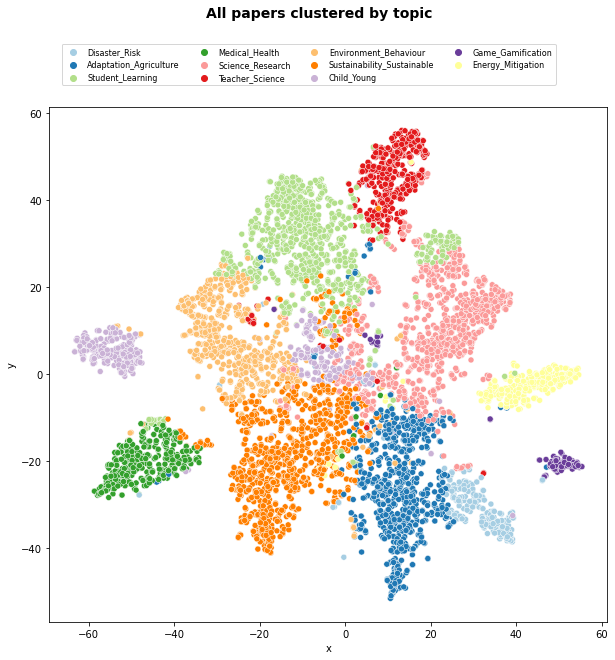

In [58]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.005)
sns.scatterplot(data=data, x="x", y="y", hue="Topic Label", palette="Paired")
#plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.legend('', frameon=False)
fig.legend(loc=(0.1,0.87),ncol=4, fontsize = 8)
plt.suptitle("All papers clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.subplots_adjust(top=0.84)
plt.savefig('../Figure_GPT2_8/Climate_Education_tse.eps',format = 'eps', bbox_inches='tight', dpi = 'figure')

In [ ]:
tsne_lsa_vectors[(npr['PubYear']<=2008) & (npr['PubYear']>2008-5)]

In [59]:
npr_topics['Topic'] = topic_results.argmax(axis=1)

In [60]:
npr_topics['Topic Label'] = npr_topics['Topic'].map(my_topic_dic)

In [61]:
npr_topics["Topic Label"].nunique()

15

In [62]:
npr_topics["Topic"].nunique()

15

In [63]:
npr_topics["Topic"].value_counts(normalize=True)*100

4     15.801850
10    14.861264
0     14.845587
5     12.619533
7     10.299420
13     6.599781
12     6.490045
1      6.223546
6      4.640226
11     3.966139
14     1.802790
2      0.595705
9      0.454617
8      0.438940
3      0.360558
Name: Topic, dtype: float64

In [64]:
topic_counts = npr_topics['Topic'].value_counts(normalize=True)*100
thresholds_2 = 1
npr_topics_select = npr_topics[npr_topics['Topic'].isin(topic_counts[topic_counts > thresholds_2].index)]

In [65]:
import matplotlib.colors as pltc
import matplotlib.ticker as mtick

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/2807110028.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)


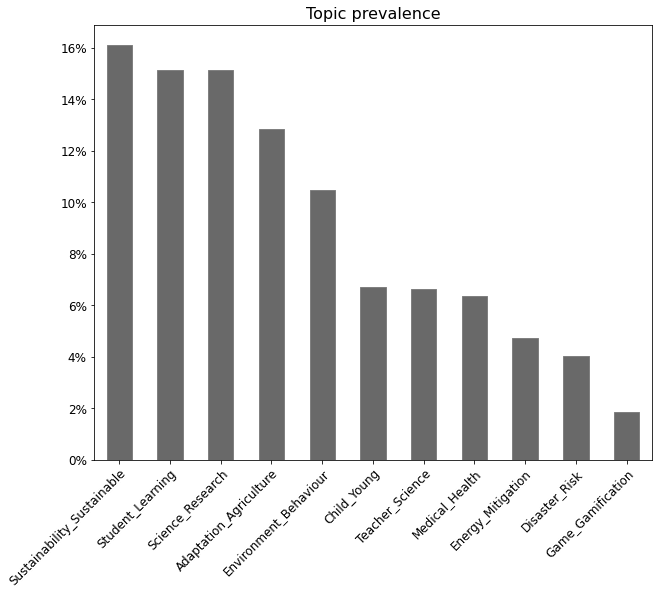

In [66]:
all_colors = [k for k,v in pltc.cnames.items()]
from random import sample
#import random
#random.seed(22)
#colors = sample(all_colors,npr_2008["Topic Label"].nunique())
#print(colors)
#ax = (npr_2008["Topic Label"].value_counts(normalize=True)*100).plot.bar(figsize = (10,8),color= colors)
ax = (npr_topics_select["Topic Label"].value_counts(normalize=True)*100).plot.bar(figsize = (10,8),color= 'dimgrey',edgecolor = 'grey')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize=12, ha='right', rotation_mode="anchor")
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
#ax.set_ylabel("Topic prevalence", fontsize=14)
ax.set_title("Topic prevalence", fontsize=16)
plt.savefig('../Figure_GPT2_8/Paper_topic.eps', format ='eps', dpi='figure',
        bbox_inches='tight', pad_inches=0.2,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [67]:
npr_topics_select["Topic Label"].value_counts(normalize=True)*100

Sustainability_Sustainable    16.099665
Student_Learning              15.141351
Science_Research              15.125379
Adaptation_Agriculture        12.857371
Environment_Behaviour         10.493531
Child_Young                    6.724165
Teacher_Science                6.612362
Medical_Health                 6.340840
Energy_Mitigation              4.727679
Disaster_Risk                  4.040888
Game_Gamification              1.836767
Name: Topic Label, dtype: float64

In [68]:
npr_topics["Topic"].value_counts(normalize=True)*100

4     15.801850
10    14.861264
0     14.845587
5     12.619533
7     10.299420
13     6.599781
12     6.490045
1      6.223546
6      4.640226
11     3.966139
14     1.802790
2      0.595705
9      0.454617
8      0.438940
3      0.360558
Name: Topic, dtype: float64

[Text(1, 0, 'topic_4'),
 Text(2, 0, 'topic_10'),
 Text(3, 0, 'topic_0'),
 Text(4, 0, 'topic_5'),
 Text(5, 0, 'topic_7'),
 Text(6, 0, 'topic_13'),
 Text(7, 0, 'topic_12'),
 Text(8, 0, 'topic_1'),
 Text(9, 0, 'topic_6'),
 Text(10, 0, 'topic_11'),
 Text(11, 0, 'topic_14')]

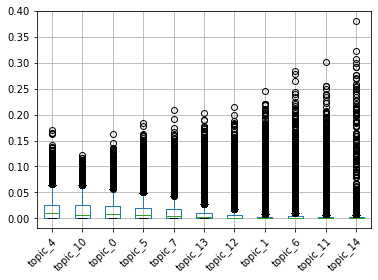

In [69]:
ax = npr_topics_select.boxplot(column = ['topic_4', 'topic_10', 'topic_0', 'topic_5','topic_7', 'topic_13', 'topic_12', 
                           'topic_1','topic_6','topic_11','topic_14'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize=10, ha='right', rotation_mode="anchor")

In [70]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x, y, hue = None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [71]:
npr_topic = npr_topics_select[['topic_4','topic_10','topic_0','topic_5','topic_7', 'topic_13', 
                      'topic_12', 'topic_1','topic_6','topic_11', 'topic_14']]

npr_topic.rename(columns={'topic_4': 'Sustainability_Sustainable', 'topic_10': 'Student_Learning',
                          'topic_0': 'Science_Research',
                          'topic_5': 'Adaptation_Agriculture',
                          'topic_7': 'Environment_Behaviour',
                          'topic_13': 'Child_young', 
                          'topic_12': 'Teacher_Science',
                          'topic_1': 'Health_Medical',
                          'topic_6': 'Energy_Mitigation',
                          'topic_11': 'Disaster_Risk',
                          'topic_14': 'Game_Gamification'
                         }, inplace = True)


/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/1912988221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_topic.rename(columns={'topic_4': 'Sustainability_Sustainable', 'topic_10': 'Student_Learning',


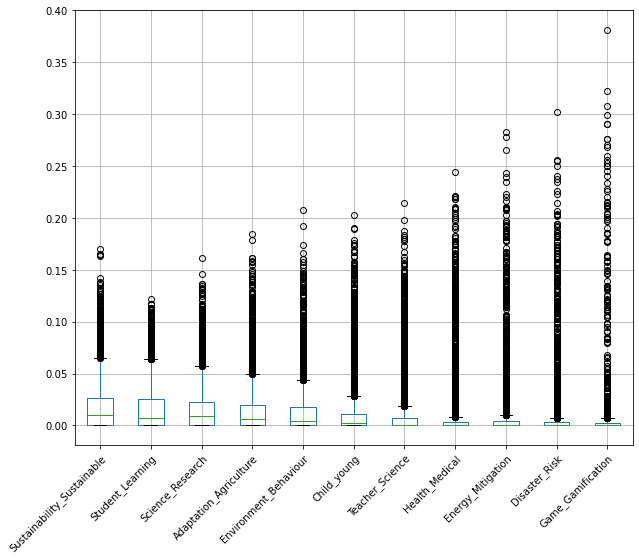

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = npr_topic.boxplot()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize=10, ha='right', rotation_mode="anchor")
plt.savefig('../Figure_GPT2_8/Boxplots.eps',dpi='figure',
        bbox_inches='tight', pad_inches=0.2,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [ ]:
plt.style.use('default')

g = sns.pairplot(
    npr_topic,
    x_vars=["Sytem_Learning_Social_Research", "Learning_School_Student", "School_Teacher_Science","Environmental_Concern_Behaviour_Child"],
    y_vars=["Sytem_Learning_Social_Research", "Learning_School_Student", "School_Teacher_Science","Environmental_Concern_Behaviour_Child"],
height=2, markers=".", diag_kind = 'hist')

#g.map_lower(corrfunc)
#plt.show()
plt.savefig('../Figure_GPT2_5/Climate_Education_pairplot.eps')

Something to try will be to make a heatmap with two topic and cross check when both of them exceed a certain threshold, e.g topic university and topic children...

In [73]:
aa1=npr_topic.corr()

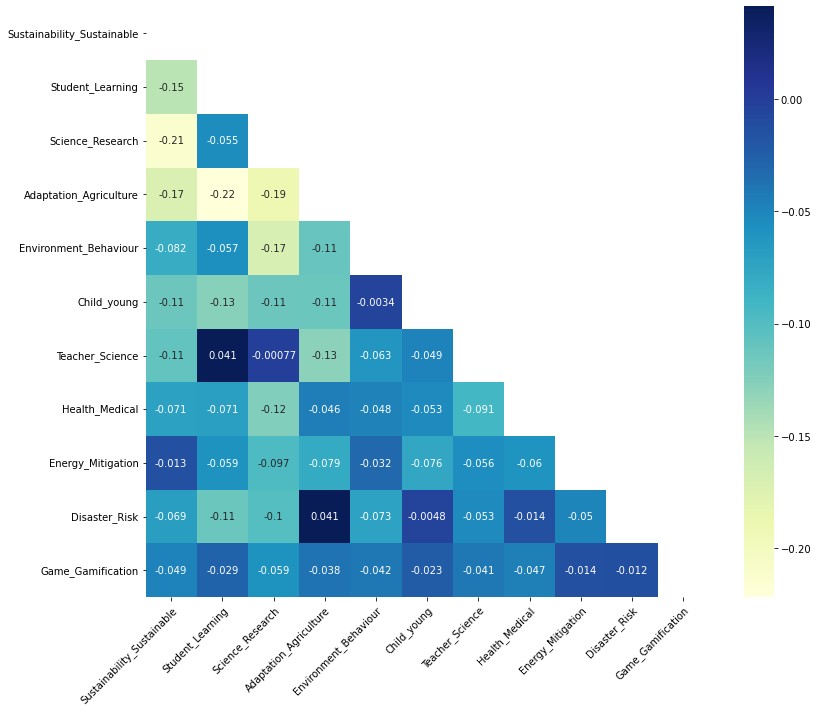

In [74]:
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(aa1))
sns.heatmap(aa1, ax=ax, annot=True, cmap='YlGnBu', mask = mask)
ax.set_xticklabels(labels =ax.get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")
ax.tick_params(axis='both', labelsize=10)
plt.tight_layout()
plt.savefig('../Figure_GPT2_8/Heatmap_topics_all.svg',dpi='figure',
        bbox_inches='tight', pad_inches=0.2,
        facecolor='auto', edgecolor='auto',
        backend=None )

In [75]:
npr_topics['Source title']= npr_topics['Source title'].str.lower().replace('proceedings of the national academy of sciences of the united states of america','pnas')

In [76]:
npr_topics['Source title'] = npr_topics['Source title'].str.lower().replace('international journal of sustainability in higher education','Int Jour Sust Higher Edu')

In [77]:
npr_topics['Source title'] = npr_topics['Source title'].str.lower().replace('international journal of environmental research and public health','IJERPH')

In [78]:
npr_topics['Source title'] = npr_topics['Source title'].str.lower().replace('international research in geographical and environmental education','Int. Res. Geogr. Environ.')

In [79]:
a = npr_topics.groupby(by=npr_topics['Source title'].str.lower())['Times cited'].sum()

b= a/(a.sum())

In [80]:
a.sum()

57426

In [81]:
c = (b*100).sort_values(ascending=False)

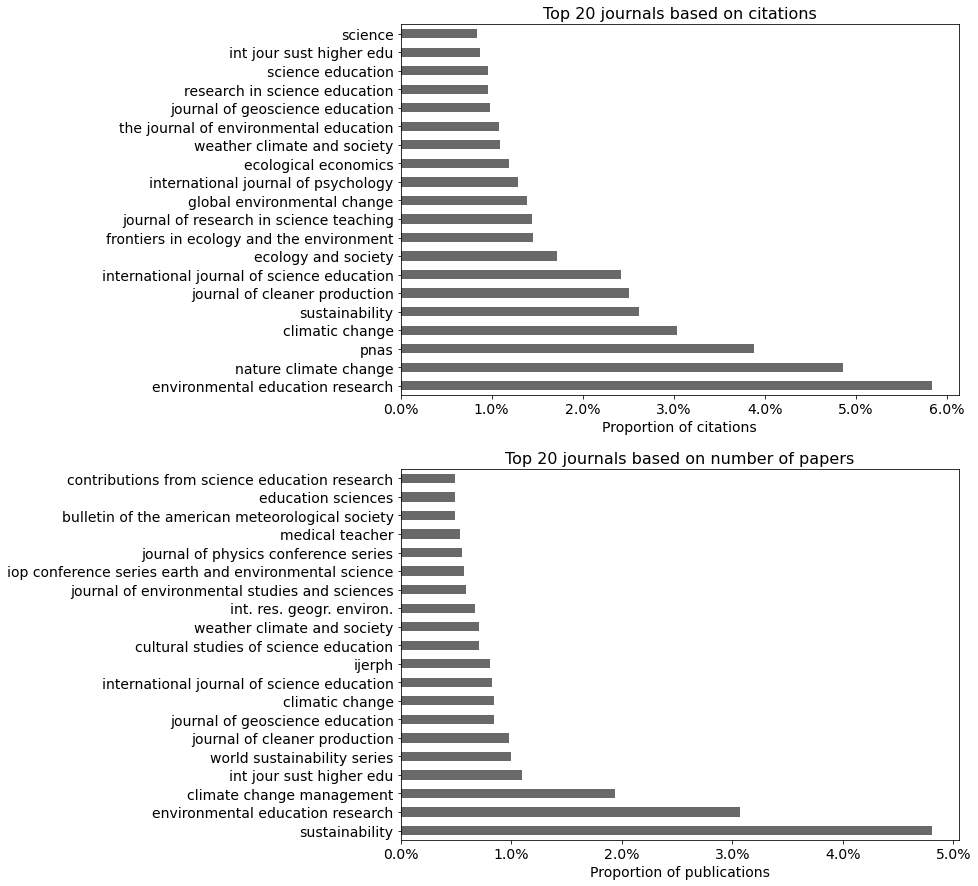

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize =(10,15))
x0 = c.head(20)
x1 = (npr_topics['Source title'].str.lower().value_counts(normalize = True)*100).head(20)

x0.plot.barh(ax=axes[0],color ='dimgrey')
axes[0].set(ylabel=None)
axes[0].set(xlabel='Proportion of citations')
axes[0].set_xlabel('Proportion of citations', fontsize=14)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
#ax.set_ylim(10000, 90000)
#ax.set_ylim(10000, 900000)
axes[0].set_title(label = 'Top 20 journals based on citations',fontsize =16)

x1.plot.barh(ax=axes[1],color ='dimgrey')
axes[1].set(ylabel=None)
axes[1].set(xlabel='Proportion of publications')
axes[1].set_xlabel('Proportion of publications', fontsize=14)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=14)
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
axes[1].tick_params(axis='both', labelsize=14)
#ax.set_ylim(10000, 90000)
#ax.set_ylim(10000, 900000)
axes[1].set_title(label = 'Top 20 journals based on number of papers',fontsize =16)

plt.savefig('../Figure_GPT2_8/Journals_citations_publications.eps', format = 'eps', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [83]:
npr_2008['Source title'].str.lower().value_counts(normalize = True).head(20)

sustainability                                                        0.048061
environmental education research                                      0.030691
climate change management                                             0.019393
international journal of sustainability in higher education           0.010961
world sustainability series                                           0.009949
journal of cleaner production                                         0.009781
journal of geoscience education                                       0.008432
climatic change                                                       0.008432
international journal of science education                            0.008263
international journal of environmental research and public health     0.008094
cultural studies of science education                                 0.007083
weather climate and society                                           0.007083
international research in geographical and environme

In [84]:
print("Do you want to save the datasets?")
x = input()
if x == 'yes':
    npr_topics.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Output_Data/npr_2008_GPT2_October2023.csv')
    npr_topics.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Output_Data/npr_2008_GPT2_October2023.xlsx',index = False, header=True)
#    npr.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.csv')
#    npr.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.xlsx',index = False, header=True)
else:
    print('No need to save because answer was: ' + x)

Do you want to save the datasets?
yes


# Geoparsing 
## We perform now some analysis based on countries and continents. 
* First we import the geo parser for geograpghical entity recognition. We use geotext
* We allocate the countries to the whole dataframe
* We then assign country codes and continents to a slice of the dataframe
* We work with this new dataframe to produce maps, spider diagrams etc...

In [85]:
#Trying GeoText. It's not able to recognise when the same countries is talked more than once in the same abstract. 
#This needs to be manually implemented in the dataframe. 
from geotext import GeoText
#places = GeoText("London is a great city")
#places.cities
# "London"
#places.country_mention
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2,country_name_to_country_alpha2,country_name_to_country_alpha3

In [86]:
#Parse countries in the Abstracts
geo_data_country = (npr_2008['Abstract']
#      .replace(r"\bUSA\b", "United States", regex=True)
       .replace((r"\bUSA\b", r"\bUS\b", r"\bU.S.\b") ,"United States",regex=True)      
       .replace((r"\bUK\b", r"\bU.K.\b") ,"United Kingdom",regex=True)                     
       .apply(lambda x: GeoText(x).countries)
)
geo_data_country.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6379 entries, 0 to 6378
Series name: Abstract
Non-Null Count  Dtype 
--------------  ----- 
6379 non-null   object
dtypes: object(1)
memory usage: 50.0+ KB


In [87]:
geo_data_country = geo_data_country.rename('Countries')

In [88]:
#Add countries as a list to the dataframe column countries
npr_topics['countries'] = geo_data_country

In [89]:
print("Do you want to save the datasets?")
x = input()
if x == 'yes':
    npr_2008.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Output_Data/npr_2008_GPT2_Geo_October2023.csv')
    npr_2008.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Output_Data/npr_2008_GPT2_Geo_October2023.xlsx',index = False, header=True)
#    npr.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.csv')
#    npr.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.xlsx',index = False, header=True)
else:
    print('No need to save because answer was: ' + x)

Do you want to save the datasets?
yes


In [122]:
print("Do you want to save the datasets?")
x = input()
if x == 'yes':
    npr_topics.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Output_Data/npr_topics_GPT2_Geo_October2023.csv')
    npr_topics.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Output_Data/npr_topics_GPT2_Geo_October2023.xlsx',index = False, header=True)
#    npr.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.csv')
#    npr.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.xlsx',index = False, header=True)
else:
    print('No need to save because answer was: ' + x)

Do you want to save the datasets?
yes


In [120]:
npr_topics

Identifier                                           Abstract  Relevant  \
0           1483  Child-centred disaster risk reduction aims to ...         1   
1          10895  This chapter reports on an ambitious action re...         1   
2          14975  Floods are the natural hazard that have the gr...         1   
3           9726  Design thinking can be broadly defined as a se...         1   
4          11479  The frequency of extreme heat events, such as ...         1   
...          ...                                                ...       ...   
6374         297  Climate change is a global challenge that thre...         1   
6375        7497  Climate change will likely have significant ef...         1   
6376       11589  Higher order thinking skills are an important ...         1   
6377         735  French coastal policies have recently put grea...         1   
6378        7742  As farmers continue to face increasingly uncer...         1   

                                  DOI  \
0                  10.1111/disa.12536   
1        10.1007/978-3-030-17187-2_11   
2                   10.3390/w14213376   
3                  10.53761/1.18.6.14   
4              10.3390/ijerph16152657   
...                               ...   
6374         10.24815/jipi.v6i1.23796   
6375                 10.3390/f7110268   
6376         10.15294/jese.v1i2.47113   
6377  10.1016/j.ocecoaman.2019.01.018   
6378                  10.1071/AN14882   

                                                  Title  \
0     Returning to normal? 'Building back better' in...   
1     Service Learning and Stakeholder Action: Techn...   
2     Teaching Floods in the Context of Climate Chan...   
3     Introducing design thinking online to large bu...   
4     Overview of Existing Heat-Health Warning Syste...   
...                                                 ...   
6374  Pemahaman Guru IPA Pra Jabatan Terhadap Mitiga...   
6375  Developing and Implementing Climate Change Ada...   
6376  Development of Problem-based Motion Graphic Vi...   
6377  The perception of climate-related coastal risk...   
6378  Empowering farmers for increased resilience in...   

                                           Source title  PubYear  \
0                                             disasters     2022   
1                international political economy series     2019   
2                                                 water     2022   
3     journal of university teaching and learning pr...     2021   
4                                                ijerph     2019   
...                                                 ...      ...   
6374                      jurnal ipa & pembelajaran ipa     2022   
6375                                            forests     2016   
6376     journal of environmental and science education     2021   
6377                         ocean & coastal management     2019   
6378                          animal production science     2015   

                                                Authors  Times cited  \
0                                        Parham, Martin            0   
1                                          Malan, Naudé            2   
2                   Olcina, J; Morote, AF; Hernandez, M            0   
3                       Vallis, Carmen; Redmond, Petrea            2   
4     Casanueva, Ana; Burgstall, Annkatrin; Kotlarsk...           51   
...                                                 ...          ...   
6374  Agustini, Meily Putri; Meilinda, Meilinda; Ais...            0   
6375  Halofsky, Jessica E.; Peterson, David L.; Metl...           10   
6376       Rani, Widiyastuti Jaya; Wusqo, Indah Urwatin            0   
6377  Goeldner-Gianella, Lydie; Grancher, Delphine; ...           11   
6378  Nettle, R.; Ayre, M.; Beilin, R.; Waller, S.; ...            6   

      Probability  ...   topic_8   topic_9  topic_10  topic_11  topic_12  \
0          100.00  ...  0.000000  0.000000  0.000000  0.163595  0.035174 

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/351708780.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


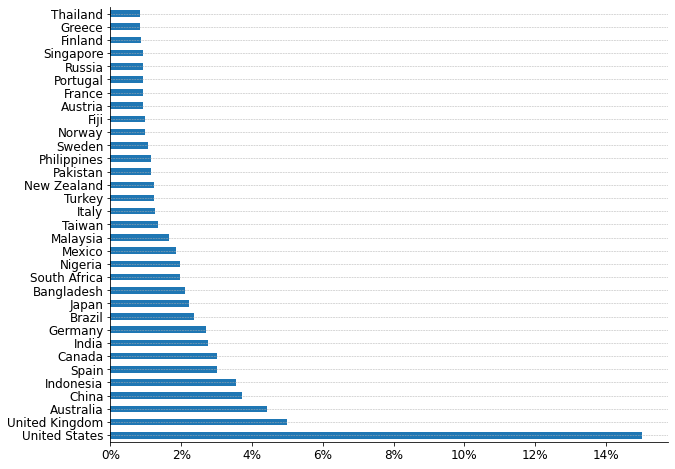

In [90]:
#The result in this figure correspond to the proportion of paper mentioning a given country out of the total of the papers 
# mentioning any country. The total of the paper mentioning a country or more in its abstract is 2261 (see below). 
ax = (npr_topics['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False, normalize=True)*100).head(33).plot.barh(figsize=(10,8))
ax.set(xlabel=None)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
#ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
ax.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.spines["bottom"].set_visible(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(True)

plt.savefig('../Figure_GPT2_8/Publications_countries.eps', format = 'eps',dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [102]:
npr_topics['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False)

United States       380
United Kingdom      126
Australia           112
China                94
Indonesia            90
                   ... 
Guinea-Bissau         1
Lesotho               1
Falkland Islands      1
Tuvalu                1
French Polynesia      1
Name: countries, Length: 162, dtype: int64

In [91]:
test = npr_topics['countries'].explode().reset_index().drop_duplicates(keep = "first")

In [92]:
test = test.set_index('index')

In [93]:
test = pd.concat([test,npr_topics['Topic Label']], axis=1)

In [94]:
test = test.dropna()

In [95]:
test = test.reset_index()

In [96]:
test = test.drop('index',axis =1)

In [97]:
sub_test = test[test.groupby('countries').countries.transform('count')>=20].copy() 

In [98]:
sub_test.head(20)

countries                 Topic Label
1     South Africa      Adaptation_Agriculture
2            Spain            Student_Learning
4           Canada               Disaster_Risk
5        Australia            Science_Research
6           Canada  Sustainability_Sustainable
8   United Kingdom  Sustainability_Sustainable
10           India                 Child_Young
11   United States  Sustainability_Sustainable
13         Germany  Sustainability_Sustainable
15       Australia  Sustainability_Sustainable
16           Spain      Adaptation_Agriculture
17          Mexico              Medical_Health
20   United States      Adaptation_Agriculture
21   United States  Sustainability_Sustainable
22          Canada  Sustainability_Sustainable
23       Indonesia               Disaster_Risk
24       Indonesia      Adaptation_Agriculture
25           Spain             Teacher_Science
27      Bangladesh             Teacher_Science
28          Mexico            Student_Learning

In [99]:
sub_test['countries'].nunique()

34

In [100]:
test['countries'].value_counts()

United States       380
United Kingdom      126
Australia           112
China                94
Indonesia            90
                   ... 
Guinea-Bissau         1
Lesotho               1
Falkland Islands      1
Tuvalu                1
French Polynesia      1
Name: countries, Length: 162, dtype: int64

In [101]:
sub_test['countries'].value_counts()

United States     380
United Kingdom    126
Australia         112
China              94
Indonesia          90
Spain              76
Canada             76
India              70
Germany            68
Brazil             60
Japan              56
Bangladesh         53
South Africa       50
Nigeria            50
Mexico             47
Malaysia           42
Taiwan             34
Italy              32
New Zealand        31
Turkey             31
Philippines        29
Pakistan           29
Sweden             27
Fiji               25
Norway             25
Portugal           23
Singapore          23
Austria            23
France             23
Russia             23
Finland            22
Thailand           21
Greece             21
Ghana              20
Name: countries, dtype: int64

In [ ]:
sub_test[sub_test['Topic Label'] == 'Science_Research']['countries'].value_counts()

In [110]:
df_plot = sub_test.groupby(['Topic Label', 'countries']).size().reset_index().pivot(columns='Topic Label', index='countries', values=0)

In [112]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, Australia to United States
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Adaptation_Agriculture      34 non-null     float64
 1   Child_Young                 25 non-null     float64
 2   Disaster_Risk               30 non-null     float64
 3   Energy_Mitigation           28 non-null     float64
 4   Environment_Behaviour       33 non-null     float64
 5   Game_Gamification           10 non-null     float64
 6   Medical_Health              24 non-null     float64
 7   Physical_Geography          5 non-null      float64
 8   Science_Research            33 non-null     float64
 9   Student_Learning            33 non-null     float64
 10  Sustainability_Sustainable  33 non-null     float64
 11  Teacher_Science             26 non-null     float64
 12  Undefined_2                 1 non-null      float64
 13  Undefined_3            

In [113]:
df_plot = df_plot.fillna(0)

In [114]:
df_plot = df_plot.iloc[:,:-2]
#df_plot = df_plot.iloc[:,:]

In [115]:
df_plot.columns = df_plot.columns.get_level_values(0)

In [116]:
df_plot

Topic Label     Adaptation_Agriculture  Child_Young  Disaster_Risk  \
countries                                                            
Australia                          9.0         21.0            7.0   
Austria                            4.0          3.0            2.0   
Bangladesh                        20.0          1.0            8.0   
Brazil                             8.0          3.0            6.0   
Canada                            13.0          1.0            8.0   
China                             16.0          2.0            6.0   
Fiji                               8.0          0.0            2.0   
Finland                            1.0          3.0            1.0   
France                             3.0          0.0            1.0   
Germany                           14.0          4.0            1.0   
Ghana                              7.0          1.0            1.0   
Greece                             3.0          2.0            3.0   
India                              9.0          7.0            7.0   
Indonesia                         12.0          5.0           20.0   
Italy                              7.0          1.0            2.0   
Japan                              4.0          5.0           11.0   
Malaysia                           8.0          0.0            3.0   
Mexico                             4.0          2.0            5.0   
New Zealand                        2.0          3.0            2.0   
Nigeria                           20.0          0.0            0.0   
Norway                             2.0          1.0            0.0   
Pakistan                           8.0          0.0            2.0   
Philippines                        8.0          0.0            8.0   
Portugal                           3.0          4.0            0.0   
Russia                             3.0          0.0            0.0   
Singapore                          4.0          1.0            1.0   
South Africa                      15.0          6.0            2.0   
Spain                              8.0          2.0            4.0   
Sweden                             4.0          1.0            1.0   
Taiwan                             4.0          0.0            4.0   
Thailand                           1.0          1.0            2.0   
Turkey                             4.0          0.0            3.0   
United Kingdom                    13.0         18.0            2.0   
United States                     47.0         13.0            9.0   

Topic Label     Energy_Mitigation  Environment_Behaviour  Game_Gamification  \
countries                                                                     
Australia                     0.0                    9.0                1.0   
Austria                       1.0                    0.0                1.0   
Bangladesh                    5.0                    2.0                0.0   
Brazil                        2.0                   10.0                1.0   
Canada                        4.0                   10.0                0.0   
China                        12.0                   19.0                0.0   
Fiji                          0.0                    1.0                0.0   
Finland                       1.0                    2.0                0.0   
France                        3.0                    3.0                0.0   
Germany                       2.0                    3.0                1.0   
Ghana                         2.0                    1.0                0.0   
Greece                        1.0                    8.0                0.0   
India                         5.0                   10.0                0.0   
Indonesia                     6.0                   12.0                0.0   
Italy                         0.0                    2.0                0.0   
Japan                         7.0                    3.0                0.0   
Malaysia                      3.0                    9.0 

In [117]:
df_plot =df_plot.astype(int)

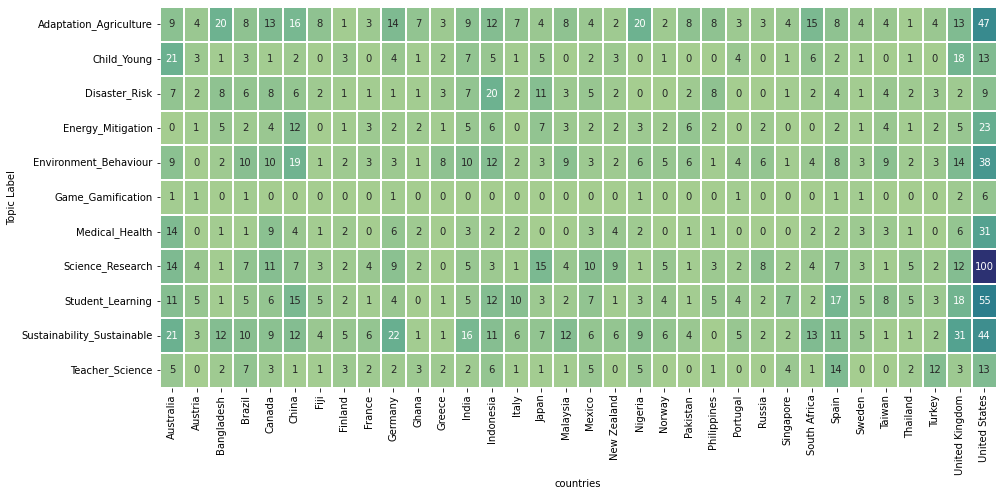

In [123]:
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.heatmap(df_plot.drop('Physical_Geography', axis=1).T, ax=ax, linecolor='white',linewidths=2,cmap="crest", cbar = False, annot = True,fmt="g")
plt.savefig('../Figure_GPT2_8/Country_Topic_association.eps', format = 'eps',dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [ ]:
#npr_new.drop_duplicates(keep = "first").head(20)

In [ ]:
#npr_new.groupby(['index', 'countries']).first()

In [124]:
df10 = npr_topics['countries'].explode().reset_index()

In [125]:
#for i, row in df10.iterrows():    
code = []
for p in df10.countries:
    try:
        aa = country_name_to_country_alpha3(p)
        code.append(aa)
    except:
        code.append('')
df10['code'] = code

In [ ]:
#npr_2008.drop('Country_0', axis = 1, inplace = True)

In [ ]:
#npr_2008['continent'].value_counts(ascending=False).head(20).plot.barh(figsize=(10,8)) #autopct='%.2f')

In [ ]:
#npr_2008['continent'].value_counts(ascending=False)

In [ ]:
npr_topics['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).head(20)

In [ ]:
npr_topics['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).sum()

In [ ]:
npr_topics['countries'].shape

In [ ]:
#Proportion of papers mentioning specific countries
(2261/5705)*100

In [126]:
df8 = npr_topics['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).rename_axis('countries').to_frame('counts')


In [127]:
npr_topics['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries']

0               Dominica
1           South Africa
3                  Spain
4                    NaN
5                    NaN
              ...       
8080       United States
8081                 NaN
8082    French Polynesia
8083         New Zealand
8084           Australia
Name: countries, Length: 6999, dtype: object

In [128]:
df8.reset_index(inplace=True)

In [129]:
df8['countries'].iloc[100:157]

100                  Myanmar
101                 Botswana
102          Solomon Islands
103                   Kosovo
104                Mauritius
105                     Mali
106                 Bulgaria
107                  Comoros
108                 Slovakia
109                 Cambodia
110                   Guyana
111                  Grenada
112       Dominican Republic
113                  Mayotte
114             Burkina Faso
115               Cape Verde
116              North Korea
117                  Namibia
118                    Tonga
119                   Guinea
120                  Uruguay
121              Afghanistan
122               Madagascar
123                  Tunisia
124               Tajikistan
125            French Guiana
126    Palestinian Territory
127                    Sudan
128                 Barbados
129              Saint Lucia
130                Guatemala
131                  Jamaica
132                    Syria
133               Kazakhstan
134           

In [130]:
#for i, row in df10.iterrows():    
code = []
continents = []
for p in df8.countries:
    try:
        aa = country_name_to_country_alpha3(p)
        b1 = country_name_to_country_alpha2(p)
        bb = country_alpha2_to_continent_code(b1)
        code.append(aa)
        continents.append(bb) 
    except:
        code.append('')
        continents.append('')
df8['code'] = code
df8['continents'] = continents

In [ ]:
df8.to_csv("check_countries.csv")  

In [131]:
df8['code'].iloc[56] = 'ATA'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/2416831186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['code'].iloc[56] = 'ATA'


In [132]:
df8['continents'].iloc[56] = 'AQ'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/340282906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['continents'].iloc[56] = 'AQ'


In [133]:
df8['code'].iloc[126] = 'PSE'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/557731325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['code'].iloc[126] = 'PSE'


In [134]:
df8['continents'].iloc[126] = 'AS'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/1096400431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['continents'].iloc[126] = 'AS'


In [135]:
df8['code'].iloc[103] = 'XK'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/123696979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['code'].iloc[103] = 'XK'


In [136]:
df8['continents'].iloc[103] = 'EU'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_71529/2555457833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['continents'].iloc[103] = 'EU'


In [138]:
df8.iloc[0:50,:]

countries  counts code continents
0    United States     380  USA         NA
1   United Kingdom     126  GBR         EU
2        Australia     112  AUS         OC
3            China      94  CHN         AS
4        Indonesia      90  IDN         AS
5            Spain      76  ESP         EU
6           Canada      76  CAN         NA
7            India      70  IND         AS
8          Germany      68  DEU         EU
9           Brazil      60  BRA         SA
10           Japan      56  JPN         AS
11      Bangladesh      53  BGD         AS
12    South Africa      50  ZAF         AF
13         Nigeria      50  NGA         AF
14          Mexico      47  MEX         NA
15        Malaysia      42  MYS         AS
16          Taiwan      34  TWN         AS
17           Italy      32  ITA         EU
18          Turkey      31  TUR         AS
19     New Zealand      31  NZL         OC
20        Pakistan      29  PAK         AS
21     Philippines      29  PHL         AS
22          Sweden      27  SWE         EU
23          Norway      25  NOR         EU
24            Fiji      25  FJI         OC
25         Austria      23  AUT         EU
26          France      23  FRA         EU
27        Portugal      23  PRT         EU
28          Russia      23  RUS         EU
29       Singapore      23  SGP         AS
30         Finland      22  FIN         EU
31          Greece      21  GRC         EU
32        Thailand      21  THA         AS
33           Ghana      20  GHA         AF
34       Hong Kong      18  HKG         AS
35         Vietnam      17  VNM         AS
36        Colombia      17  COL         SA
37          Poland      17  POL         EU
38           Chile      17  CHL         SA
39           Nepal      15  NPL         AS
40        Zimbabwe      15  ZWE         AF
41           Kenya      14  KEN         AF
42         Denmark      14  DNK         EU
43        Tanzania      13  TZA         AF
44       Sri Lanka      13  LKA         AS
45         Ukraine      13  UKR         EU
46     Netherlands      13  NLD         EU
47         Ireland      11  IRL         EU
48          Uganda      11  UGA         AF
49          Israel      10  ISR         AS

In [149]:
import plotly.express as px
import plotly.graph_objects as go
import kaleido

fig = go.Figure(data=go.Choropleth(
    locations = df8['code'],
    z = df8['counts'],
    text = df8['countries'],
    colorscale = 'sunsetdark',
    autocolorscale=False,
    reversescale=False,
    #marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Country count', 
))
fig.update_geos(projection_type="natural earth", showcountries = True,showlakes = False,
                showocean=True, oceancolor="LightBlue")

fig.update_layout(title_text = 'Geographical distributions of case studies')
                                                                                                               
fig.show()

fig.write_image("../Figure_GPT2_8/Map_2.svg")

#plt.savefig('../Figure_GPT2_6/Map_2.eps', dpi=400)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


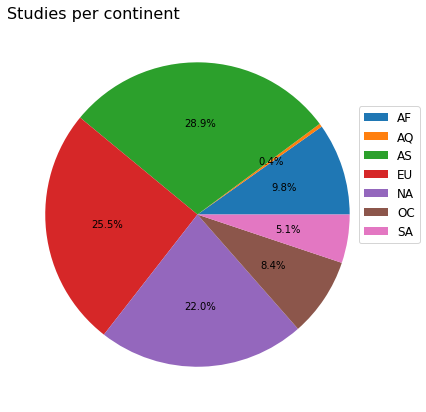

In [139]:
aa = df8.groupby(df8['continents']).sum()
ax = aa.plot.pie(subplots=True,figsize=(7,7),legend = True, autopct='%1.1f%%', labeldistance = None)
plt.ylabel(None)
plt.title('Studies per continent',fontsize =16, loc="left")
plt.legend(bbox_to_anchor=(1.1, 0.8), fontsize = 12)
figure_name = 'Pie_Chart_Continents'
plt.savefig('../Figure_GPT2_8/Pie_continents.eps', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
plt.show()

In [ ]:
aa.index

In [140]:
my_continets = {'AF': 'Africa', 'AQ':'Antarctica', 'AS': 'Asia',
               'EU': 'Europe', 'NA':'North America', 'OC': 'Oceania','SA': 'South America'}

In [141]:
aa.index = aa.index.map(my_continets)

In [142]:
aa

counts
continents           
Africa            248
Antarctica          9
Asia              730
Europe            644
North America     557
Oceania           212
South America     130

In [ ]:
aa['counts'][i]

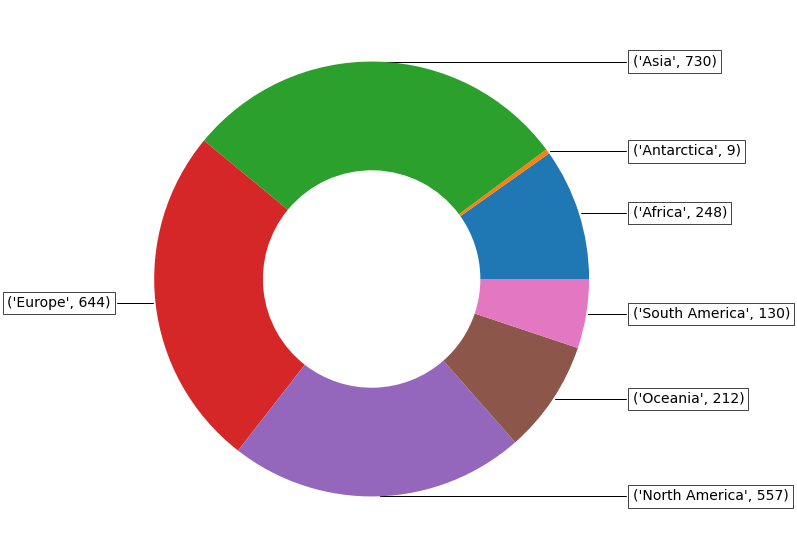

In [150]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10),subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(aa['counts'], wedgeprops=dict(width=0.5))
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate((aa.index[i],aa['counts'][i]), xy=(x, y), xytext=(1.2*np.sign(x), 1*y),
                horizontalalignment=horizontalalignment, **kw, fontsize=14)

#ax.set_title("Matplotlib bakery: A donut")
figure_name = 'Pie_Chart_Continents'
plt.savefig('../Figure_GPT2_8/Donuts_continents.eps', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
plt.show()

In [144]:
df12 = df8.groupby(df8['continents']).sum()

In [145]:
df12.reset_index(inplace=True)

In [146]:
full_name = ['Africa', 'Antarctica', 'Asia', 'Europe', 'N. America', 'S. America', 'Oceania'] 
df12['Continent_Full_Name'] = full_name

In [ ]:
df12

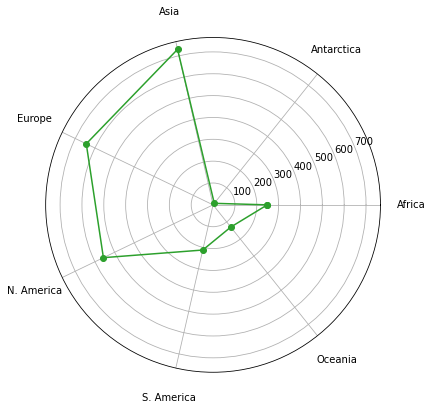

In [147]:
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111, projection="polar")

# theta has 7 different angles, and the first one repeated
theta = np.arange(len(df12) + 1) / float(len(df12)) * 2 * np.pi
# values has the 7 values from 'counts', with the first element repeated
values = df12['counts'].values
values = np.append(values, values[0])

# draw the polygon and the mark the points for each angle/value combination
l1, = ax.plot(theta, values, color="C2", marker="o", label="counts")
plt.xticks(theta[:-1], df12['Continent_Full_Name'], color='black', size=10)
ax.tick_params(pad=20,labelrotation =0) # to increase the distance of the labels to the plot
# fill the area of the polygon with green and some transparency
#ax.fill(theta, values, 'blue', alpha=0.1)

#plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
#plt.title("Title")
plt.show()

In [148]:
df10 = npr_topics[npr_topics['Topic'] == 1]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).rename_axis('countries').to_frame('counts')


In [ ]:
from collections import Counter
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
topic_results.shape

In [ ]:
nmf_keys = get_keys(topic_results)
nmf_categories, nmf_counts = keys_to_counts(nmf_keys)

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [ ]:
len(nmf_keys)

In [ ]:
n_topics = 15

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii','ignore').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
top_n_words_nmf = get_top_n_words(2, nmf_keys, dtm,tfidf)

for i in range(len(top_n_words_nmf)):
    print("Topic {}: ".format(i+1), top_n_words_nmf[i])

In [ ]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
tsne_lsa_vectors_2 = tsne_lsa_model.fit_transform(topic_results)

In [ ]:
nmf_mean_topic_vectors = get_mean_topic_vectors(nmf_keys, tsne_lsa_vectors_2)

In [ ]:
tsne_lsa_vectors[:]

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
plot = figure(title="t-SNE Clustering of {} NMF Topics".format(n_topics), width=1000, height=1000)
plot.scatter(x=tsne_lsa_vectors_2[:,0], y=tsne_lsa_vectors_2[:,1], color=colormap[nmf_keys])

for t in range(n_topics):
    label = Label(x=nmf_mean_topic_vectors[t][0], y=nmf_mean_topic_vectors[t][1], 
                  text=top_n_words_nmf[t], text_color='black', text_align='center', x_offset=0, y_offset=-8)
    plot.add_layout(label)

show(plot)
#colormap[t]